In [ ]:
import numpy as np
import pandas as pd
import os
import shutil
import glob
import re
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from keras import optimizers, losses, activations, models
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
from keras.layers import Dense, Input, Dropout, Convolution1D, MaxPool1D, GlobalMaxPool1D, GlobalAveragePooling1D, concatenate

Using TensorFlow backend.


In [ ]:
def find_peaks(seg_arr, coef):
    mean = np.mean(seg_arr)
    sections = []
    section = {}
    for i, val in enumerate(seg_arr):
        if val > mean * coef:
            section[i] = val
        else:
            if len(section) != 0:
                sections.append(section)
            section = {}
    peaks_list = []
    for section in sections:
        maximum = max(section, key=section.get)  # Just use 'min' instead of 'max' for minimum.
        peaks_list.append(maximum)
    return peaks_list


In [ ]:
def find_troughs(seg_arr, coef):
    mean = np.mean(seg_arr)
    sections = []
    section = {}
    for i, val in enumerate(seg_arr):
        if val < mean * coef:
            section[i] = val
        else:
            if len(section) != 0:
                sections.append(section)
            section = {}
    troughs_list = []
    for section in sections:
        minimum = min(section, key=section.get)  # Just use 'min' instead of 'max' for minimum.
        troughs_list.append(minimum)
    return troughs_list
    

In [ ]:
df = pd.read_csv("sample1.csv")
df_resp_data = df.iloc[:, 0:1]
arr_resp_data = df_resp_data.to_numpy().T.flatten()
arr_resp_data = arr_resp_data[::100]

In [ ]:
coef_peak = 2.5   # adjust by yourself
coef_trough = -1.2   # adjust by yourself
peaks_list = find_peaks(arr_resp_data, coef_peak)
troughs_list = find_troughs(arr_resp_data, coef_trough)
print(len(peaks_list))

242


In [ ]:
peaks_list_new = []
for i in peaks_list:
    # filter some of the unqualified peaks
    if arr_resp_data[i] > 0.5:
        peaks_list_new.append(i)
print(len(peaks_list_new))


99


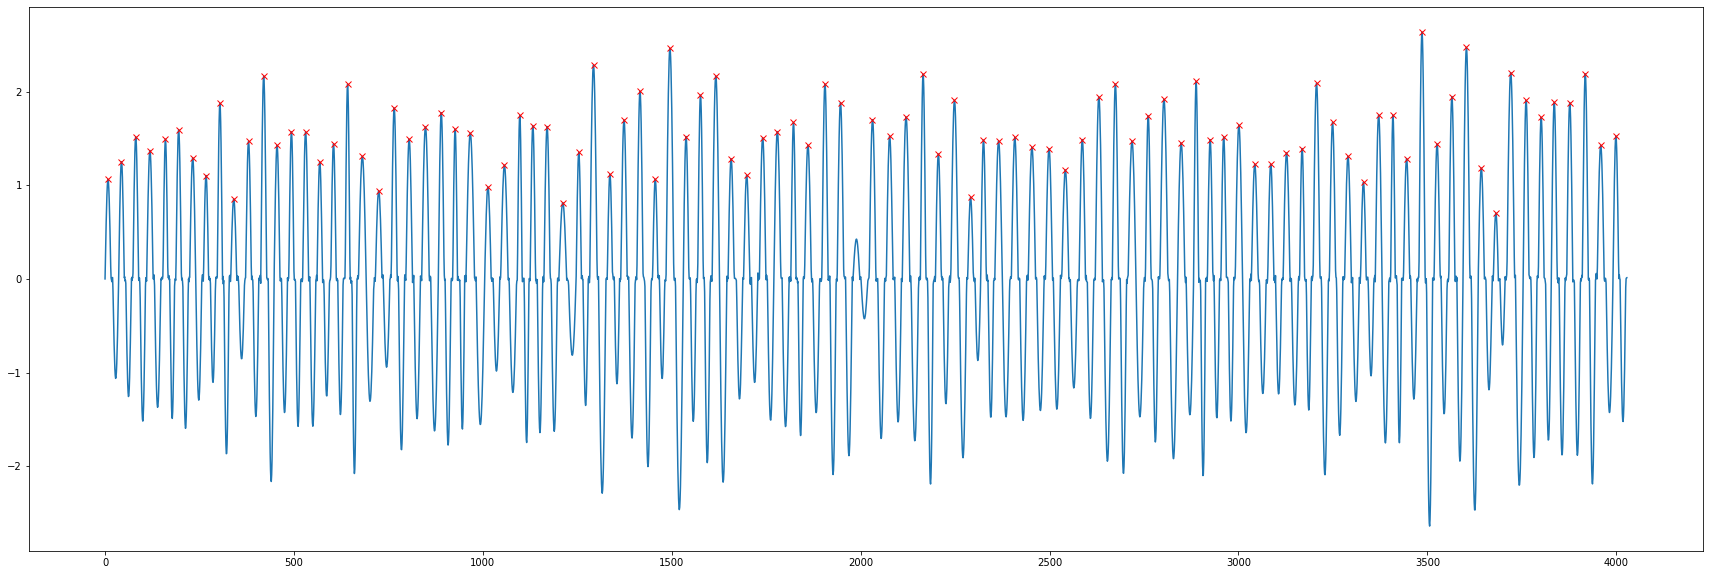

In [ ]:
plt.figure(figsize=(30, 10))
plt.plot(arr_resp_data)
plt.plot(peaks_list_new, arr_resp_data[peaks_list_new], "rx")
plt.show()

In [ ]:
def breath_segmentation(arr_resp_data, peak_inds):
    signals = [] 
    anns = []
    count = 1

    for peak in peak_inds[1:-1]:
        diff1 = abs(peak_inds[count - 1] - peak)
        diff2 = abs(peak_inds[count + 1] - peak)
        start = peak_inds[count - 1] + diff1 // 2
        end =  peak_inds[count + 1] - diff2 // 2
        signal = arr_resp_data[start: end]
        count += 1

        signal = signal - np.mean(signal)
        if len(signal) < 100:
            signal = np.concatenate([signal, np.zeros(100-len(signal))])
            signals.append(signal)
            anns.append(0)

    return signals, anns

signals, anns = breath_segmentation(arr_resp_data, peaks_list_new)

signals_csv = np.matrix(signals)
anns_csv = np.matrix(anns)
print(signals_csv.shape, anns_csv.shape)

comb_sig_ann = np.concatenate((signals_csv, anns_csv.T), axis=1)
df = pd.DataFrame(comb_sig_ann)
df.to_csv('pattern5.csv', index=False)

(97, 100) (1, 97)


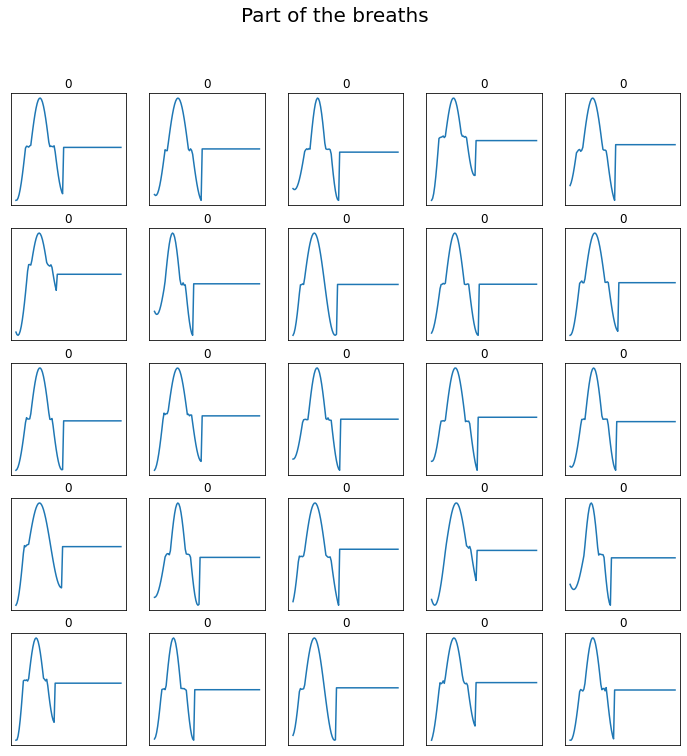

In [ ]:
def plot_segments(signals, title):
    plt.figure(figsize=(12, 12))
    col_num = 5
    row_num = 5
    signal_nums = 25
    k = 2
    for i in range(signal_nums):
        plt.subplot(row_num, col_num, i+1)
        plt.plot(signals[i + k*signal_nums]) # pay attention to the range
        plt.title(anns[i + k*signal_nums])
        plt.xticks([])
        plt.yticks([])
    plt.suptitle(title, size=20) 
    plt.show()

#check part of the hearbeats
plot_segments(signals, 'Part of the breaths')

In [ ]:
df = pd.read_csv("pattern.csv", skiprows=[0], header=None)
X = np.array(df[list(range(100))].values)[..., np.newaxis]
y = np.array(df[100].values).astype(np.int8)
#separate the datasets into the training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
y_train.shape

(328,)

In [ ]:
def get_model():
    nclass = 5
    inp = Input(shape=(100, 1))
    img_1 = Convolution1D(16, kernel_size=5, activation=activations.relu, padding="valid")(inp)
    img_1 = Convolution1D(16, kernel_size=5, activation=activations.relu, padding="valid")(img_1)
    img_1 = MaxPool1D(pool_size=2)(img_1)
    img_1 = Dropout(rate=0.1)(img_1)
    img_1 = Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = MaxPool1D(pool_size=2)(img_1)
    img_1 = Dropout(rate=0.1)(img_1)
    img_1 = Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = MaxPool1D(pool_size=2)(img_1)
    img_1 = Dropout(rate=0.1)(img_1)
    img_1 = Convolution1D(256, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = Convolution1D(256, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = GlobalMaxPool1D()(img_1)
    img_1 = Dropout(rate=0.2)(img_1)

    dense_1 = Dense(64, activation=activations.relu, name="dense_1")(img_1)
    dense_1 = Dense(64, activation=activations.relu, name="dense_2")(dense_1)
    dense_1 = Dense(nclass, activation=activations.softmax, name="dense_3_patterns")(dense_1)

    model = models.Model(inputs=inp, outputs=dense_1)
    opt = optimizers.Adam(0.001)

    model.compile(optimizer=opt, loss=losses.sparse_categorical_crossentropy, metrics=['acc'])
    model.summary()
    return model

model = get_model()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 100, 1)            0         
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 96, 16)            96        
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 92, 16)            1296      
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 46, 16)            0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 46, 16)            0         
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 44, 32)            1568      
_________________________________________________________________
conv1d_20 (Conv1D)           (None, 42, 32)            3104

In [ ]:
file_path = "breaths_classification.h5"
checkpoint = ModelCheckpoint(file_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early = EarlyStopping(monitor="val_acc", mode="max", patience=5, verbose=1)
redonplat = ReduceLROnPlateau(monitor="val_acc", mode="max", patience=3, verbose=2)
callbacks_list = [checkpoint, early, redonplat] 

model.fit(X_train, y_train, epochs=30, verbose=2, callbacks=callbacks_list, validation_split=0.1)
model.save("breaths_model.h5") 
model.load_weights(file_path)

pred_test = model.predict(X_test)
pred_test = np.argmax(pred_test, axis=-1)

f1 = f1_score(y_test, pred_test, average="macro")
print("Test f1 score : %s "% f1)

acc = accuracy_score(y_test, pred_test)
print("Test accuracy score : %s "% acc)

Train on 295 samples, validate on 33 samples
Epoch 1/30
 - 0s - loss: 0.6885 - acc: 0.8644 - val_loss: 0.5709 - val_acc: 0.9697

Epoch 00001: val_acc improved from -inf to 0.96970, saving model to breaths_classification.h5
Epoch 2/30
 - 0s - loss: 0.7034 - acc: 0.8678 - val_loss: 0.5699 - val_acc: 0.9697

Epoch 00002: val_acc did not improve from 0.96970
Epoch 3/30
 - 0s - loss: 0.6867 - acc: 0.8814 - val_loss: 0.5689 - val_acc: 0.9697

Epoch 00003: val_acc did not improve from 0.96970
Epoch 4/30
 - 0s - loss: 0.6788 - acc: 0.8780 - val_loss: 0.5679 - val_acc: 0.9697

Epoch 00004: val_acc did not improve from 0.96970

Epoch 00004: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.
Epoch 5/30
 - 0s - loss: 0.6823 - acc: 0.8746 - val_loss: 0.5679 - val_acc: 0.9697

Epoch 00005: val_acc did not improve from 0.96970
Epoch 6/30
 - 0s - loss: 0.6900 - acc: 0.8780 - val_loss: 0.5678 - val_acc: 0.9697

Epoch 00006: val_acc did not improve from 0.96970
Epoch 00006: early stoppi

In [ ]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.grid(True)
  plt.title(title)
  plt.legend()
  plt.show()
  # plt.savefig('loss.png', dpi=fig.dpi)

plot_train_history(multi_step_history, "loss")

In [ ]:
X_test.shape

(141, 100, 1)